# Lab 7: Sequential Network Architectures

## by Michael Doherty, Leilani Guzman, and Carson Pittman

"We've been trying to reach you about your car's extended warranty." There are few things more annoying in life than answering your phone and hearing these words. With technology being readily available to many people throughout the world, these types of scams have become much more prevalent. These "spam" messages, while not always scams, rarely add anything to society.

While advancing technology has allowed spam messages to increase in numbers over the years, it has also allowed for new ways to combat these messages. These spam detection filters can automatically block any incoming calls, emails, texts, etc. that appear to be suspicious; however, these filters need to be fairly refined, as blocking too many legitimate messages would lead to distrust in the filter's reliability.

Our dataset, titled "SMS Spam Collection Dataset", is comprised of over 5000 text messages in English, with each being tagged as either <code>spam</code> or <code>ham</code> (which means it's a legitimate message). Our task is to create a Sequential Network that can classify text messages as either <code>spam</code> or <code>ham</code>.

Link to the dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

## 1. Preparation
### 1.1 Preprocessing and Tokenization
To start, we'll first read in the data.

In [1]:
import pandas as pd

df = pd.read_csv("data/spam.csv", encoding='ISO-8859-1')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As seen above, the dataset seems to include some useless columns... Let's go ahead and remove those. We'll also rename our remaining columns so their purpose is clearer and change the labels to integers (where 0 is <code>ham</code> and 1 is <code>spam</code>).

In [2]:
df.drop(labels=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

df.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace=True)
df['Label'] = df['Label'].replace({'ham': 0, 'spam': 1})

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   int64 
 1   Text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


,Label,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Now that our dataset is looking better, let's tokenize the words in our <code>Text</code> variable. In the first part of this process we will fit the Keras Tokenizer on the <code>Text</code>  column, which will also build an internal vocabulary based on the frequency of words. Then, we will transform each entry in the <code>Text</code> column to a sequence of integers based on this vocabulary. Finally, we will pad the sequences so that they are all the same length, which will ensure that we can represent our input as a single matrix, ensuring compatibility with our models architecture. At the end of this process we will have our tokenized input $X$ and our corresponding labels $y$.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_review_length = 6000
tokenizer = Tokenizer(num_words=max_review_length)
tokenizer.fit_on_texts(df["Text"])

print("\nVocabulary:")
print(len(tokenizer.word_index))
VOCAB_SIZE = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(df["Text"])
X = pad_sequences(X, padding='post')
y = df['Label']

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)


Vocabulary:
8920

Shape of X: (5572, 189)
Shape of y: (5572,)


Now that we're done with preprocessing and tokenization, our final dataset can be described as follows:

- <code>Label</code>: The target variable; 0 means <code>ham</code> (a legitimate message), 1 means <code>spam</code> (not a legitimate message).
- <code>Text</code>: The content of the text message, which is tokenized.

### 1.2 Performance Metric
Now that we have our final dataset, let's visualize the distribution of values for our target variable <code>Label</code>; this will help us determine a suitable performance metric for our models.

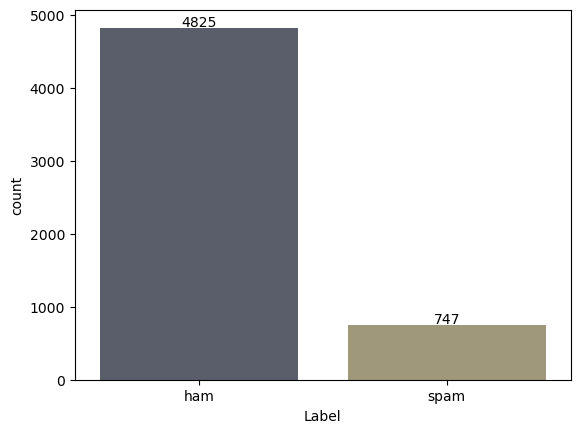

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x=df['Label'], palette='cividis')

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.xticks([0,1], ['ham', 'spam'])
plt.show()

As seen above, there are significantly more messages labeled as <code>ham</code> than <code>spam</code>; thus, accuracy would not be a good metric (as it would be skewed towards the <code>ham</code> label). For this classification task, we care about both precision (making sure the messages we label as <code>spam</code> are actually spam) and recall (making sure all spam messages are labeled as <code>spam</code>). 

Precision is important, as we don't want to label legitimate messages as <code>spam</code> (as this would annoy users and make them distrust the legitimacy of our model); however, recall is also important, as we want to identify as many spam messages as possible. After all, a highly precise model that only identifies 1 out of 100 spam messages as actually being spam isn't ideal. Thus, we will use **F1 Score** as our evaluation metric, as it takes both precision and recall into account.

### 1.3 Training and Testing Method

Now that we have our performance metric, we need to split our dataset into training and testing data. As we saw earlier, the labels in this dataset aren't balanced (as there are far more <code>ham</code> messages than <code>spam</code> messages). Thus, we will use StratifiedKFold to split our data into 5 splits for cross validation. StratifiedKFold ensures that each fold contains the same proportion of <code>ham</code> and <code>spam</code> messages. Furthermore, 5 splits allows for an 80/20 train test split (where our model trains on 80% of the data and uses the other 20% as validation data). Due to the large amount of data available to us, we believe this is sufficient.

We believe this cross validation method is a realistic mirroring of how an algorithm would be used in practice, as this dataset is public information available for anyone to use. The cross validations splits would need to be stratified due to the class imbalance in the dataset, and 5 folds is sufficient, as an 80/20 train test split is a common practice in machine learning.

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
import random
import numpy as np

mean_fpr = np.linspace(0, 1, 100)

def get_f1_score(X, y, new_model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    f1_scores = []
    mean_tpr_list = []
    auc_list = []
    yhats = []

    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        history, yhat = new_model(X_train, X_test, y_train, y_test)
        print(f"Fold {i}")
        i += 1

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(history.history['f1_metric'], label='training')

        plt.ylabel('F1 Score %')
        plt.xlabel('epochs')
        plt.title('Training')
        plt.plot(history.history['val_f1_metric'], label='validation')
        plt.title('F1 Score')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='training')
        plt.ylabel('Training Loss')
        plt.xlabel('epochs')

        plt.plot(history.history['val_loss'], label='validation')
        plt.xlabel('epochs')
        plt.title('Loss')
        plt.legend()
        plt.show()

        f1_scores.append(history.history['val_f1_metric'][-1])
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        mean_tpr_list.append(np.interp(mean_fpr, fpr, tpr))
        auc_list.append(auc(fpr, tpr))
        yhats.append(yhat)

    plt.bar(range(len(f1_scores)), f1_scores)
    plt.ylim([min(f1_scores) - 0.01, max(f1_scores)])
    plt.title('Validation F1 Score')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    print("Average F1 Score:", np.mean(f1_scores))
    
    return f1_scores, mean_tpr_list, auc_list

## 2. Modeling

### 2.1 Model Creation

#### 2.1.1 Model 1: CNN Sequential Network
Now let's start creating our models! We'll first create a basic Sequential Convolutional Neural Network. In this network, we'll use three convolution layers with subsequent MaxPooling and Dropout layers. These serve to extract important features in our data. We'll also use MaxPooling to downsample and reduce the size of the feature map, as well as Dropout to reduce the effects of overfitting our data. Then we'll use the mean and standard deviation to create a combined feature representation to make our features more representative of our data. Finally, we'll send our features through a dense Relu layer, then a sigmoid layer to classify our extracted features.

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score, make_scorer
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")

NUM_CLASSES = 1
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    return tf.py_function(f1_score, (y_true, y_pred), tf.double)

# adapted from Dr. Larson's notebook 13a. Sequence Basics [experimental]

def CNN_Seq(X_train, X_test, y_train, y_test):
    EMBED_SIZE = 100
    sequence_input = Input(shape=(X_train.shape[1],))

    embedded_sequences = Embedding(max_review_length,
                                    EMBED_SIZE,
                                    input_length=max_review_length)(sequence_input)
    
    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)
    
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)
    x = Dropout(0.2)(x)

    x_mean = GlobalAveragePooling1D()(x)
    x_tmp = Subtract()([x,x_mean])
    x_std = GlobalAveragePooling1D()(x_tmp**2)

    x = Concatenate(name='concat_1')([x_mean,x_std])

    x = Dense(64, activation='relu',
                kernel_initializer='he_uniform')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(NUM_CLASSES, activation='sigmoid',
                        kernel_initializer='glorot_uniform')(x)
    
    cnn = Model(sequence_input, predictions)
    cnn.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = cnn.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    verbose=0)
    
    yhat = np.round(cnn.predict(X_test))

    return history, yhat

35/35 [==============================] - 0s 5ms/step
Fold 1


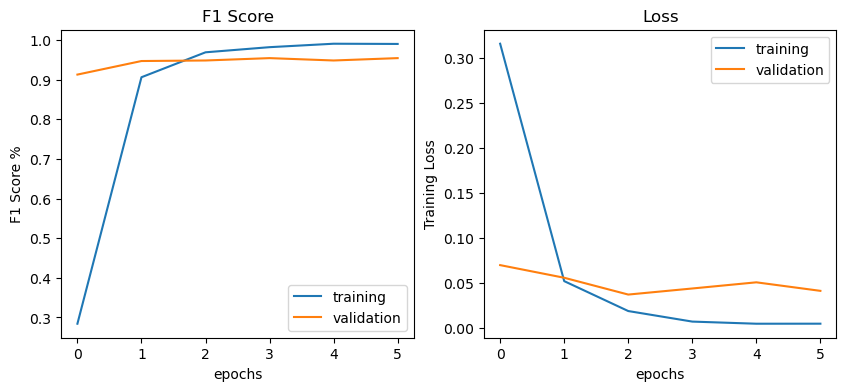

35/35 [==============================] - 0s 4ms/step
Fold 2


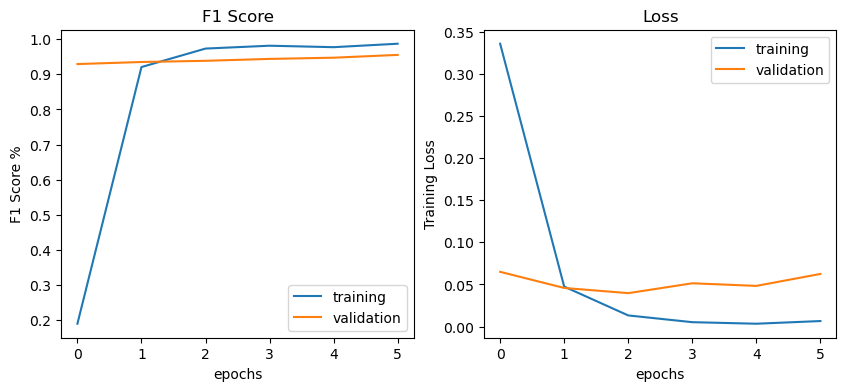

35/35 [==============================] - 0s 5ms/step
Fold 3


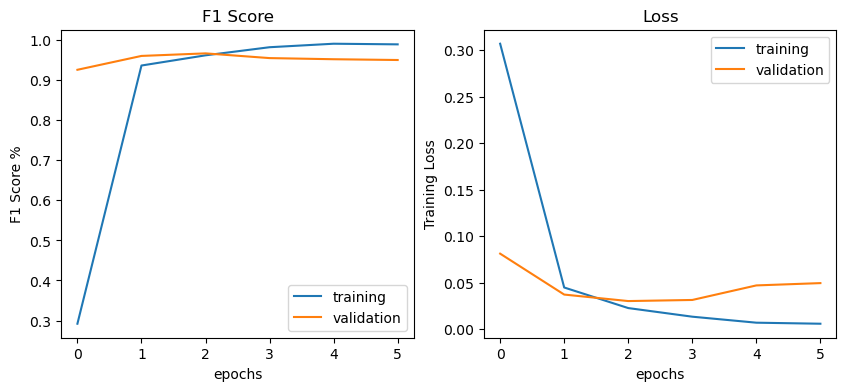

35/35 [==============================] - 0s 5ms/step
Fold 4


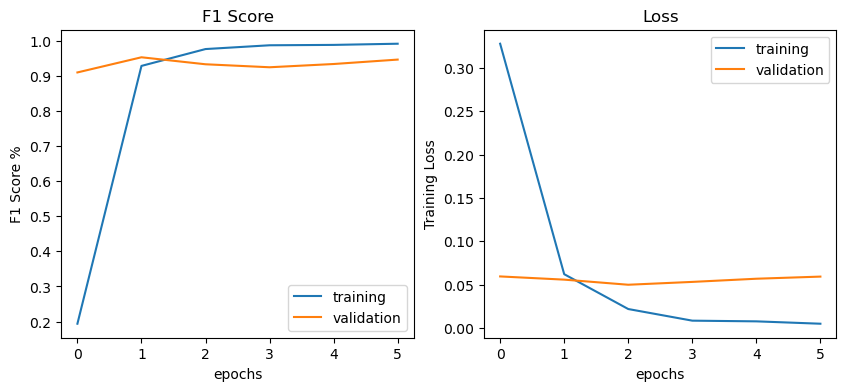

35/35 [==============================] - 0s 5ms/step
Fold 5


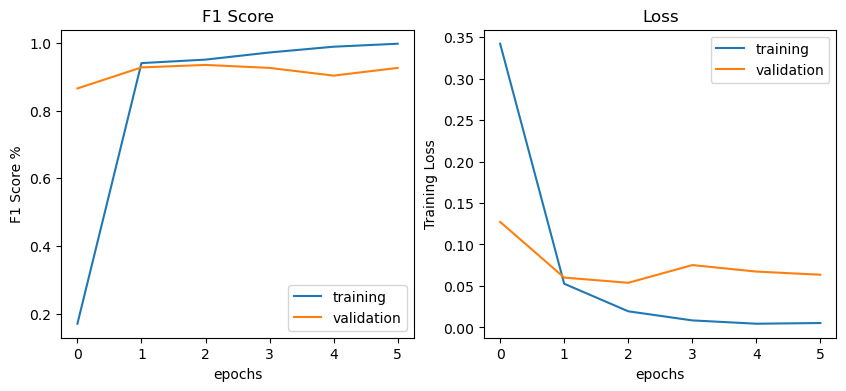

Average F1 Score: 0.9463836431503296


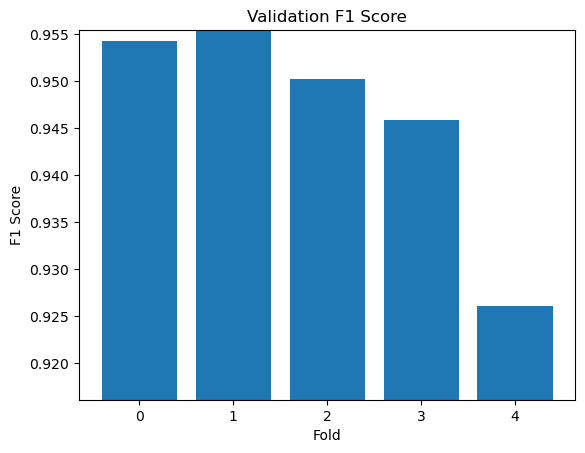

In [12]:
f1_scores_cnn, mean_tpr_list_cnn, auc_list_cnn = get_f1_score(X, y, CNN_Seq)

As seen above, this Sequential CNN did pretty good! It's average F1 score was about **94.64%**, and it only had a variance of about 3% across all 5 folds. Additionally, the loss graphs show that the models do seem to converge. Thus, it seems that this model does a pretty adequate job at classifying images as either <code>spam</code> or <code>ham</code>. Let's see if we can improve upon this model's F1 score.

#### 2.1.2 Model 2: Transformer Sequential Network
For our second model, we'll create a basic Transformer Sequential Network for classifying text as spam or not. Following the basic transformer design architecture, this model will integrate some essential components such as multi-headed attention, layer normalization, feedforward layers, and residual connections. We will also utilize our token and positional embeddings to enable our model to learn both semantic relationships and positional information in the input sequences.


In [13]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# adapted from Dr. Larson's notebook 13a. Sequence Basics [experimental]

# The transformer architecture
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # Setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)
       
        # Make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
       
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        # Apply the layers as needed
        # Get the attention output from multi heads
        # Using same inpout here is self-attention
        # Call inputs are (query, value, key)
        # If only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
       
        # Create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
       
        # Apply dropout if training
        out1 = self.dropout1(out1, training=training)
       
        # Place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
       
        # Apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)


    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [14]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def seq_transformer(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding(X_train.shape[1], VOCAB_SIZE, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    xformer = Model(inputs=inputs, outputs=outputs)

    xformer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(xformer.predict(X_test))

    return history, yhat

35/35 [==============================] - 1s 28ms/step
Fold 1


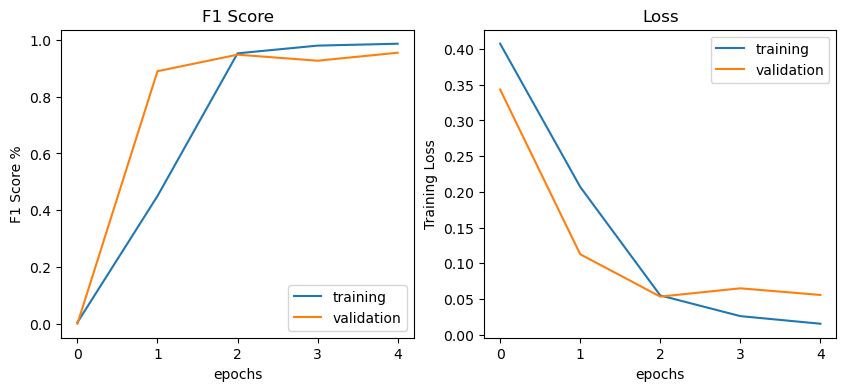

35/35 [==============================] - 1s 27ms/step
Fold 2


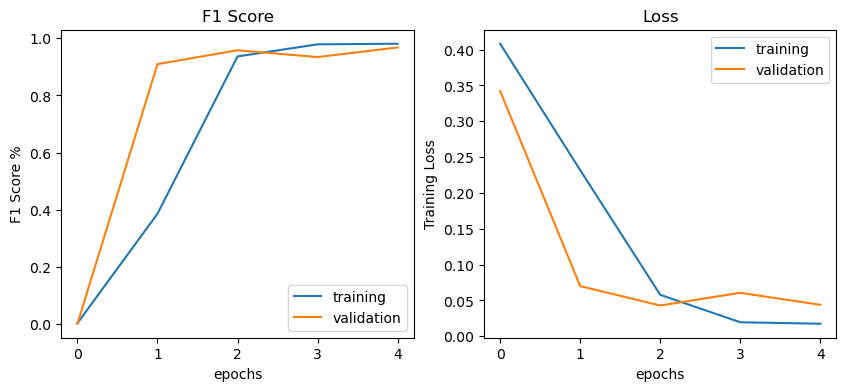

35/35 [==============================] - 1s 27ms/step
Fold 3


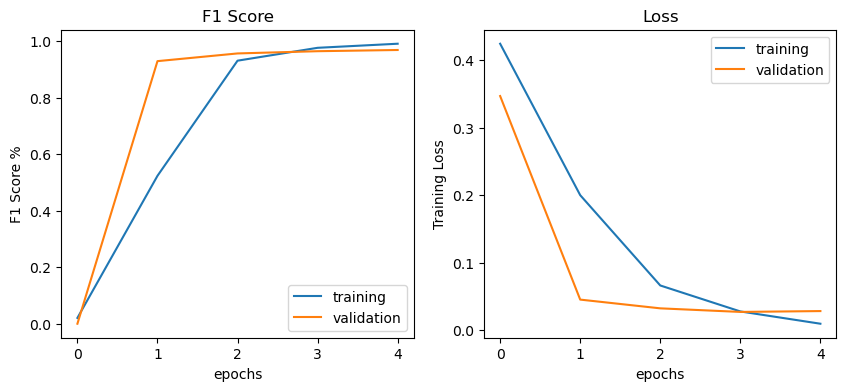

35/35 [==============================] - 1s 30ms/step
Fold 4


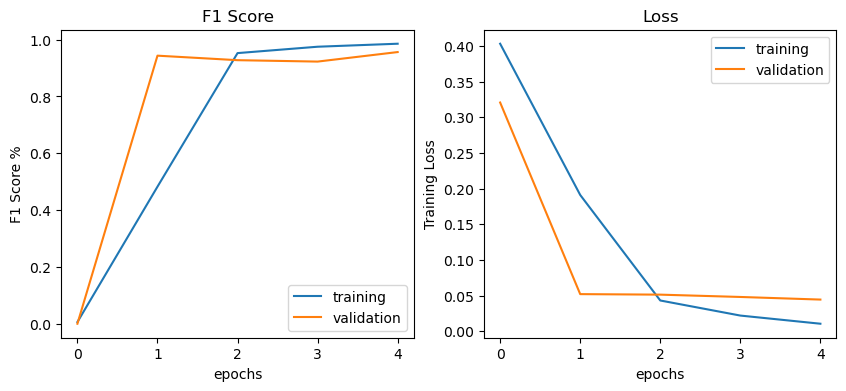

35/35 [==============================] - 2s 38ms/step
Fold 5


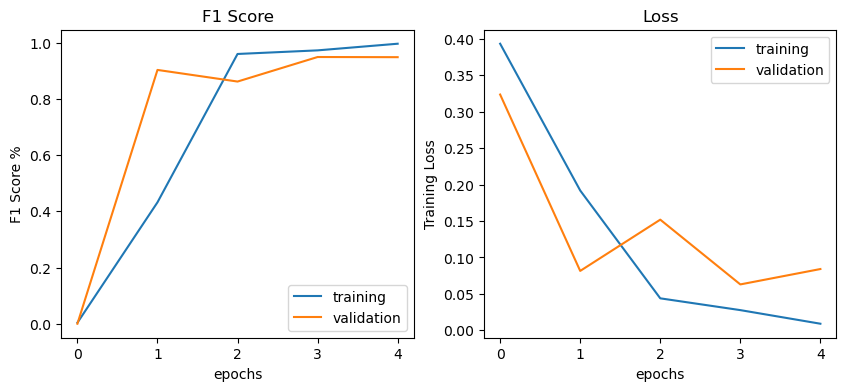

Average F1 Score: 0.959447693824768


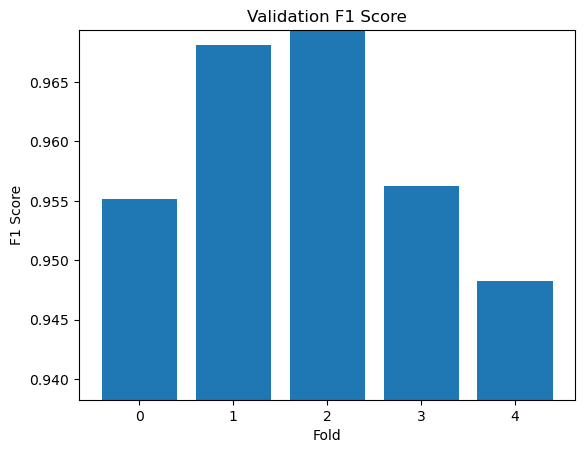

In [15]:
f1_scores_trans, mean_tpr_list_trans, auc_list_trans = get_f1_score(X, y, seq_transformer)

As seen above, our Sequential Transformer also performed well, achieving an average F1 score of **95.94%** (which is better than our Sequential CNN's average F1 score). Furthermore, its variance across 5 folds is about 2%, which is once again an improvement over the Sequential CNN. Its loss graph for each fold also looks good, as they indicate that the model converges. Thus, it seems that our Sequential Transformer is also very good at this classification task.

#### 2.1.3 Model 3: Modified CNN Sequential Network
Let's try modifying the hyperparameters of our first Sequential CNN to see if we can improve its performance. Specifically, we'll increase all of the dropout layers from 20% to 30%.

In [16]:
def CNN_Seq2(X_train, X_test, y_train, y_test):
    EMBED_SIZE = 100
    sequence_input = Input(shape=(X_train.shape[1],))

    embedded_sequences = Embedding(max_review_length,
                                    EMBED_SIZE,
                                    input_length=max_review_length)(sequence_input)
    
    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)
    
    x = MaxPooling1D(5)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)
    x = Dropout(0.3)(x)

    x_mean = GlobalAveragePooling1D()(x)
    x_tmp = Subtract()([x,x_mean])
    x_std = GlobalAveragePooling1D()(x_tmp**2)

    x = Concatenate(name='concat_1')([x_mean,x_std])

    x = Dense(64, activation='relu',
                kernel_initializer='he_uniform')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(NUM_CLASSES, activation='sigmoid',
                        kernel_initializer='glorot_uniform')(x)
    
    cnn = Model(sequence_input, predictions)
    cnn.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = cnn.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    verbose=0)
    
    yhat = np.round(cnn.predict(X_test))

    return history, yhat

35/35 [==============================] - 1s 4ms/step
Fold 1


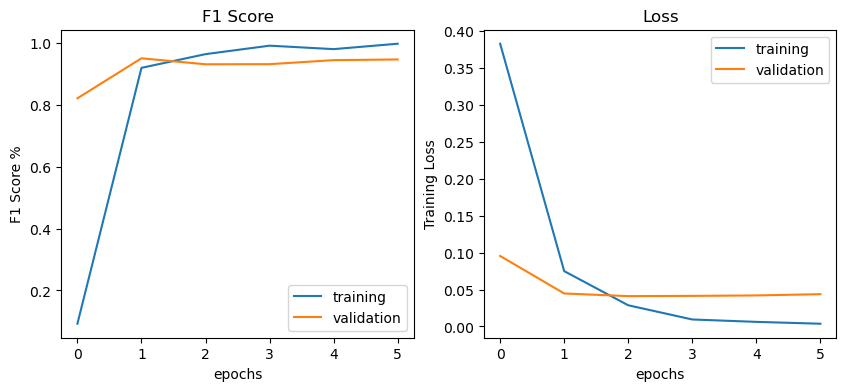

35/35 [==============================] - 0s 4ms/step
Fold 2


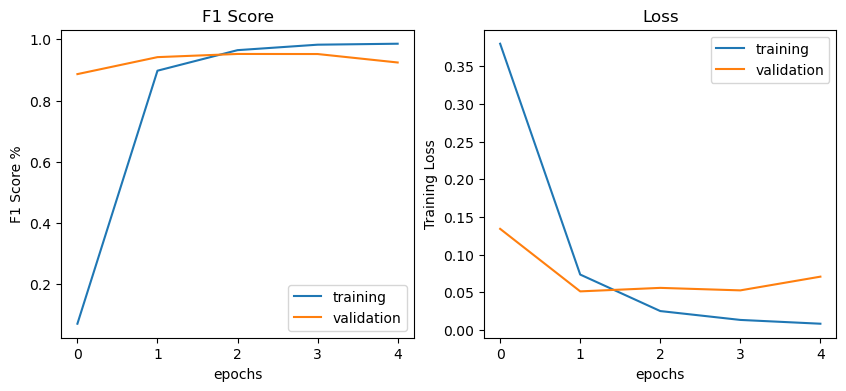

35/35 [==============================] - 0s 6ms/step
Fold 3


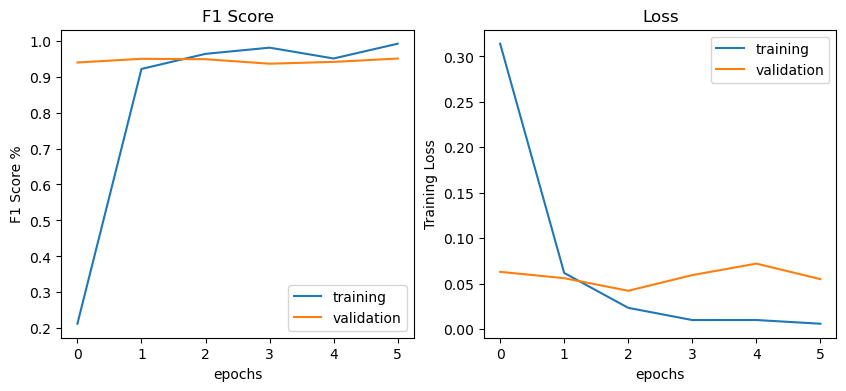

35/35 [==============================] - 0s 5ms/step
Fold 4


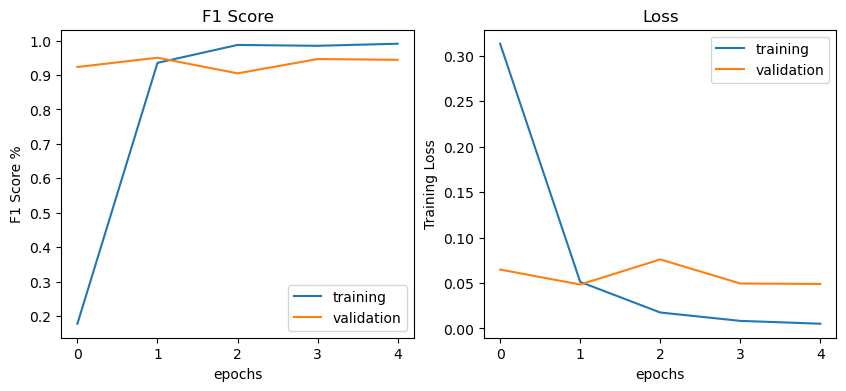

35/35 [==============================] - 0s 5ms/step
Fold 5


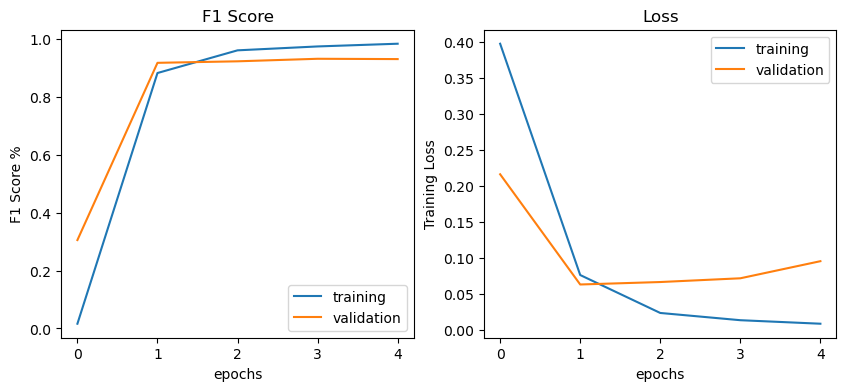

Average F1 Score: 0.9393067002296448


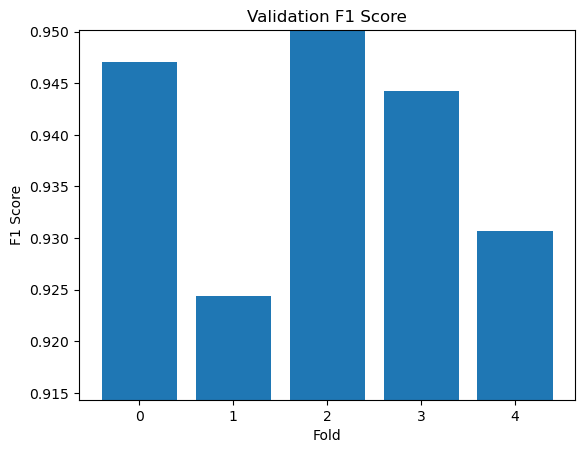

In [17]:
f1_scores_cnn_mod, mean_tpr_list_cnn_mod, auc_list_cnn_mod = get_f1_score(X, y, CNN_Seq2)

With different hyperparameters, our Modified Sequential CNN also performed pretty well. However, its average F1 score of **93.93%** was lower than our original Sequential CNN's average F1 score of 94.64%. However, it did have a slightly lower variance across folds, with only 2.5% across all 5 folds. Once again, its loss graphs also indicate that the model converges. While it does have the lowest average F1 score of all models we've looked at so far, it still proves to be competent at classifying text messages.

#### 2.1.4 Model 4: Modified Transformer Sequential Network
Now let's try modifying the hyperparameters of our Sequential Transformer. Specifically, we'll change the number of neurons in our second to last Dense layer from 20 to 40 to see if we can boost its performance.

In [18]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def seq_transformer2(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding(X_train.shape[1], VOCAB_SIZE, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(40, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    xformer = Model(inputs=inputs, outputs=outputs)

    xformer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(xformer.predict(X_test))

    return history, yhat

35/35 [==============================] - 1s 27ms/step
Fold 1


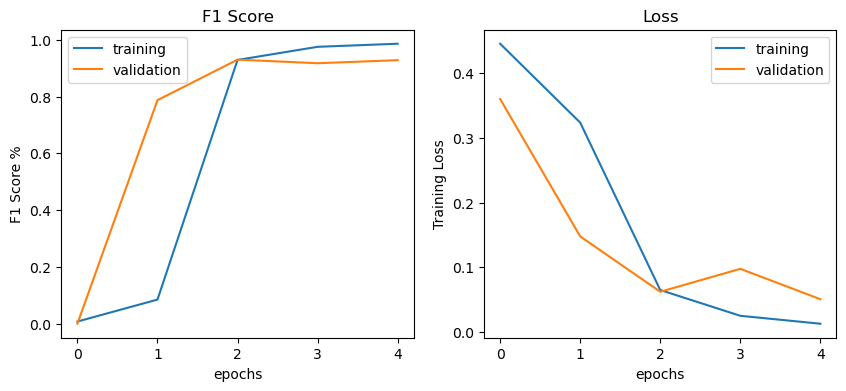

35/35 [==============================] - 1s 28ms/step
Fold 2


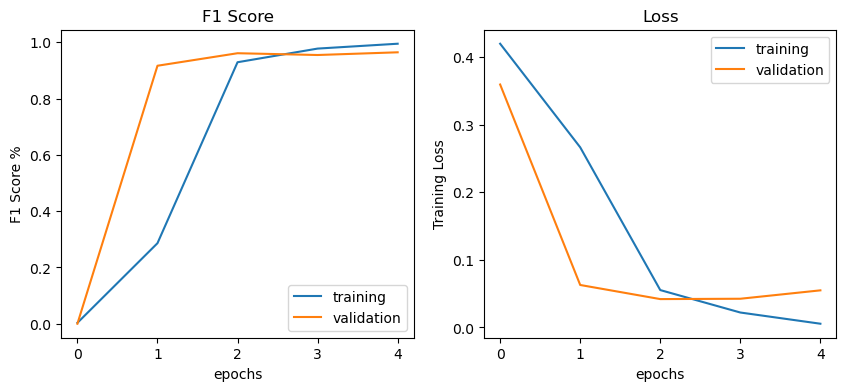

35/35 [==============================] - 1s 28ms/step
Fold 3


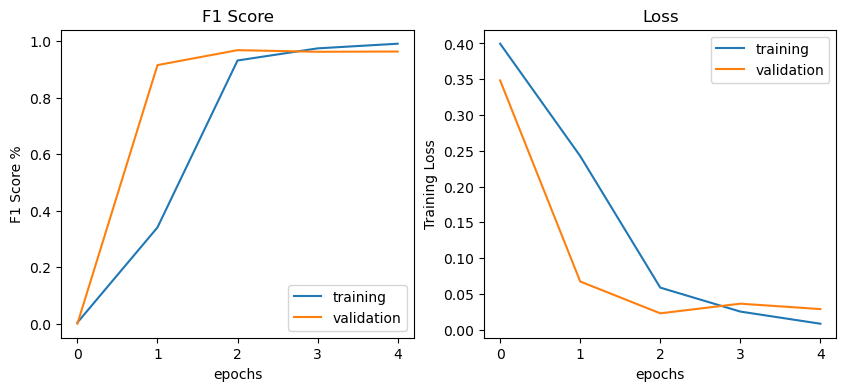

35/35 [==============================] - 1s 26ms/step
Fold 4


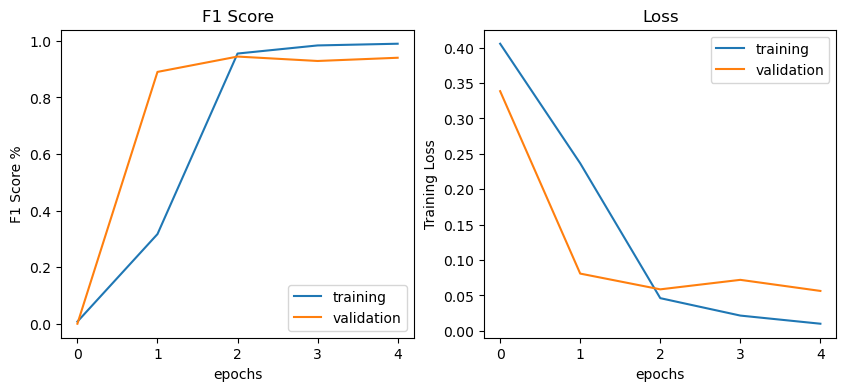

35/35 [==============================] - 2s 32ms/step
Fold 5


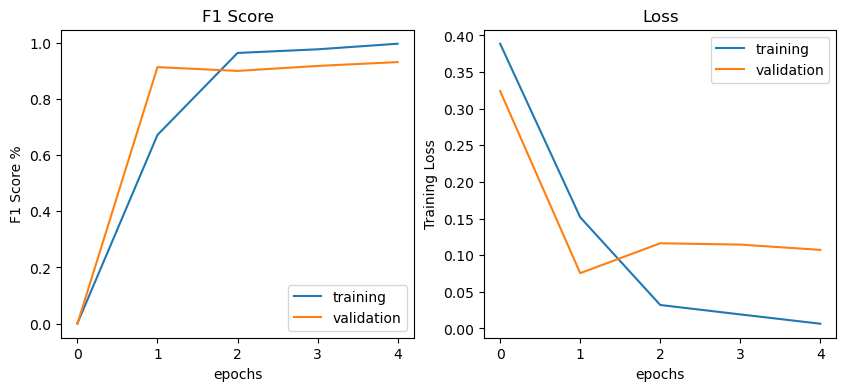

Average F1 Score: 0.9452923893928528


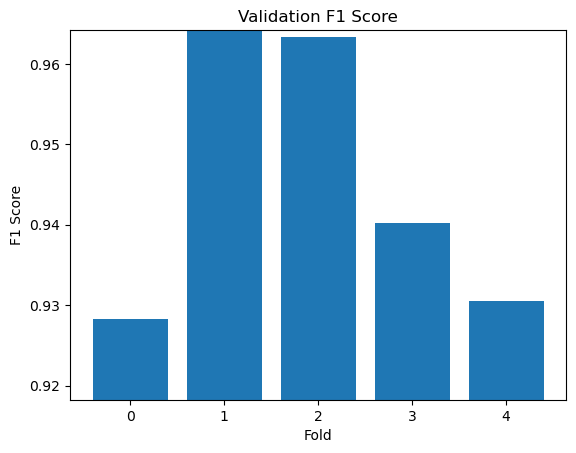

In [19]:
f1_scores_trans_mod, mean_tpr_list_trans_mod, auc_list_trans_mod = get_f1_score(X, y, seq_transformer2)

As seen above, our Modified Sequential Transformer seemed to do a pretty good job. It had an average F1 score of **94.53%** with a variance of around 3% across all 5 folds. However, these values are worse than our original Sequential Transformer, indicating that this model might be inferior. Nevertheless, its loss graphs also show that the model converges, and this model also appears to be fairly good at its classification task.

### 2.2 Adding Second Attention Layer to the Transformer
Now let's try adding a second Multi-headed self attention layer to our Transformer network! We'll use the hyperparameters from our first Sequential Transformer, as it had a higher average F1 score.

In [22]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer


# The transformer architecture
class TransformerBlock2(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # Setup the model heads and feedforward network
        self.att1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)
        # Adding second attention layer
        self.att2 = MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim)
       
        # Make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
       
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)


    def call(self, inputs, training):
        attn_output1 = self.att1(inputs, inputs)
       
        # Create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output1)
        out1 = self.dropout1(out1, training=training)
       
        attn_output2 = self.att2(out1, out1)
        out2 = self.layernorm2(out1 + attn_output2)
        out2 = self.dropout2(out2, training=training)

        # Place through feed forward after layer norm
        ffn_output = self.ffn(out2)
        out3 = self.layernorm3(out2 + ffn_output)
        out3 = self.dropout3(out3, training=training)
        #return the residual from Dense layer
        return out3

class TokenAndPositionEmbedding2(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)


    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [23]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# Transformer with a second mulit-head attention layer
def seq_transformer3(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding2(X_train.shape[1], VOCAB_SIZE, embed_dim)(inputs)
    x = TransformerBlock2(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock2(embed_dim, num_heads, ff_dim)(x) # Adding second attention layer

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    xformer = Model(inputs=inputs, outputs=outputs)

    xformer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])

    history = xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(xformer.predict(X_test))

    return history, yhat

35/35 [==============================] - 4s 105ms/step
Fold 1


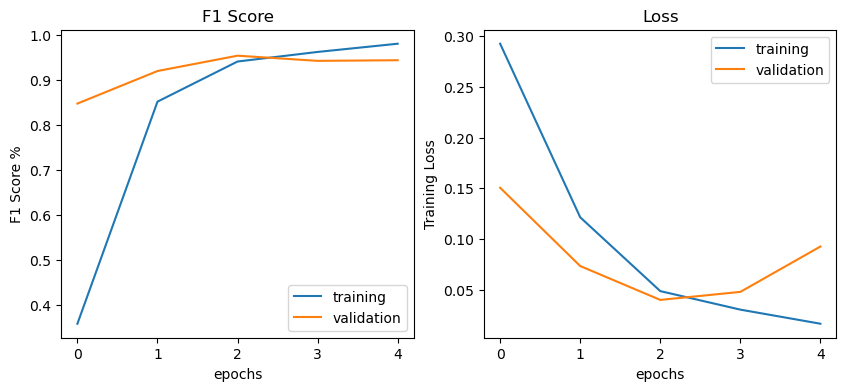

35/35 [==============================] - 4s 99ms/step
Fold 2


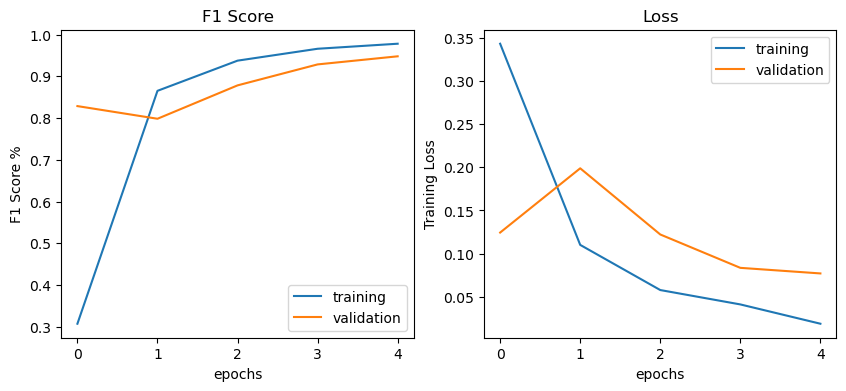

35/35 [==============================] - 4s 91ms/step
Fold 3


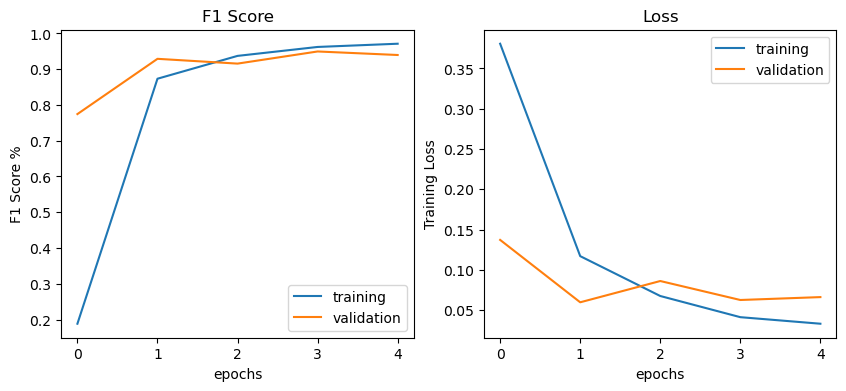

35/35 [==============================] - 4s 101ms/step
Fold 4


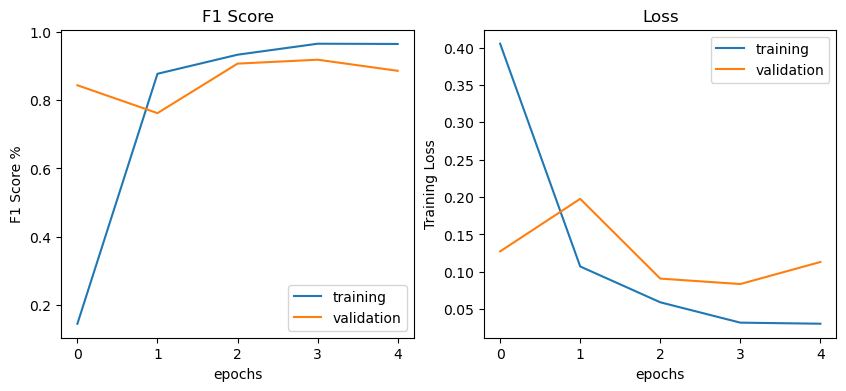

35/35 [==============================] - 5s 101ms/step
Fold 5


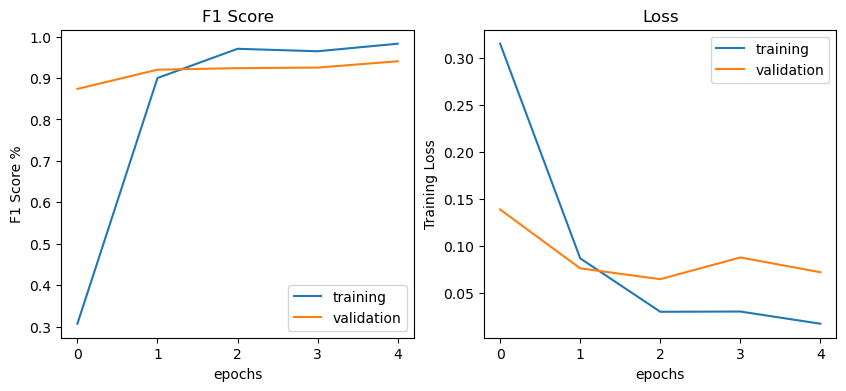

Average F1 Score: 0.9318662285804749


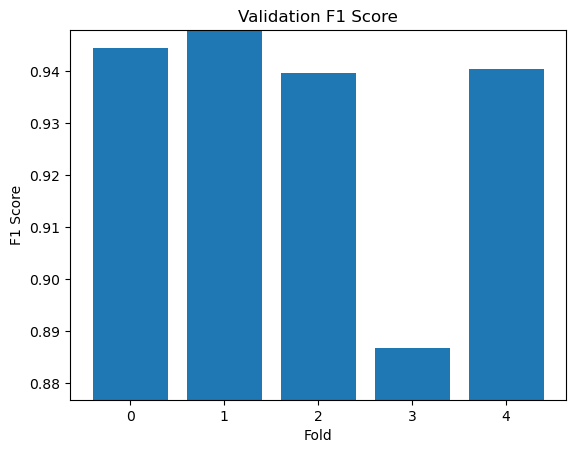

In [24]:
f1_scores_trans_2, mean_tpr_list_trans_2, auc_list_trans_2 = get_f1_score(X, y, seq_transformer2)

As seen above, this Transformer appeared to perform worse than all of our models. It had the lowest average F1 score (**93.19%**), and it had a variance of close to 6% across its folds. It is worth pointing out that the model performed significantly worse in the 4 fold (achieving an F1 score of less than 89%, which is much lower than all of the other folds). This indicates that this model may not be super consistent (and therefore, may not be as reliable). Nevertheless, its loss graphs indicate that the model seems to converge.

**NOTE: For the rest of this report, we will refer to this model as Transformer 2, as it has 2 Multi-headed self attention layers.**

### 2.3 Model Comparison
So which of our models is best? Let's first visualize their performances.

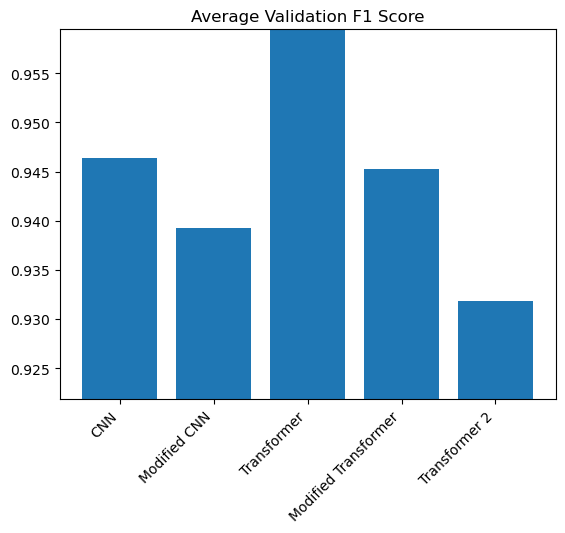

In [28]:
f1_scores = [np.mean(f1_scores_cnn), np.mean(f1_scores_cnn_mod), np.mean(f1_scores_trans), np.mean(f1_scores_trans_mod), np.mean(f1_scores_trans_2)]

plt.bar(['CNN', 'Modified CNN', 'Transformer', 'Modified Transformer', 'Transformer 2'], f1_scores)
plt.ylim([min(f1_scores) - 0.01, max(f1_scores)])
plt.xticks(rotation=45, ha='right')
plt.title('Average Validation F1 Score')
plt.show()

As seen above, our original Sequential Transformer performed the best, followed by our original Sequential CNN and our Modified Sequential Transformer. Our Transformer 2 model performed the worst (with a fairly sizable gap between it and our original Sequential Transformer). However, we can't say for certain that a model is better just because it has a higher average F1 score. Thus, let's compare the models using their ROC curves to see if we can gain any more insight.

(0.8, 1.0)

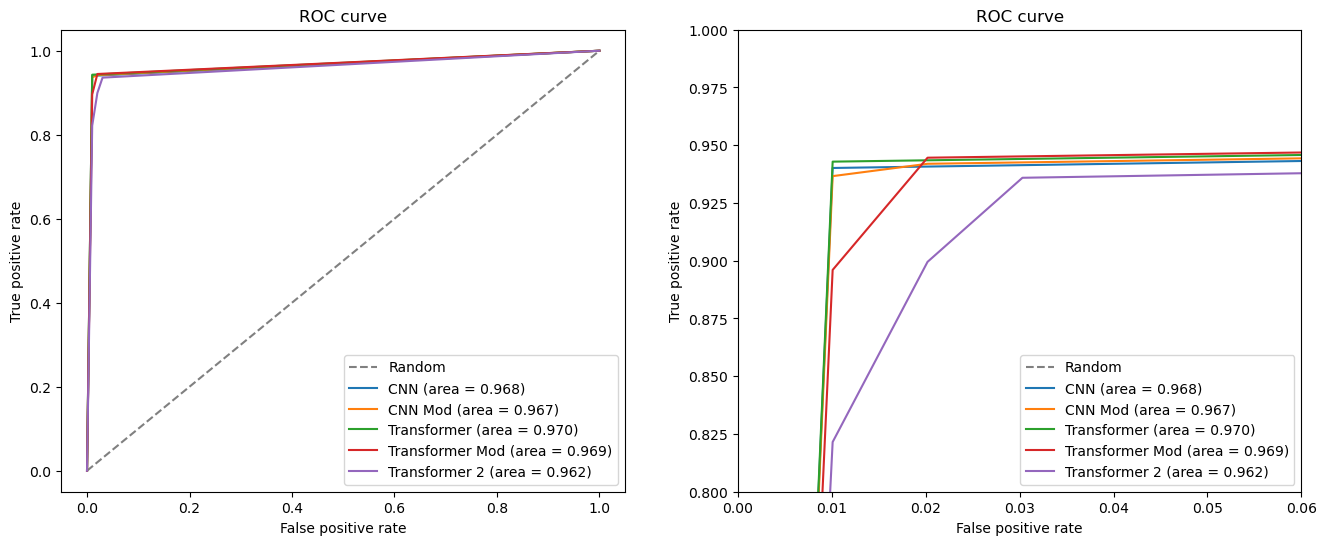

In [29]:
# Compare the 5 models using the receiver operating characteristic (ROC) curve
mean_tpr_cnn = np.mean(mean_tpr_list_cnn, axis=0)
mean_auc_cnn = np.mean(auc_list_cnn)

mean_tpr_cnn_mod = np.mean(mean_tpr_list_cnn_mod, axis=0)
mean_auc_cnn_mod = np.mean(auc_list_cnn_mod)

mean_tpr_trans = np.mean(mean_tpr_list_trans, axis=0)
mean_auc_trans = np.mean(auc_list_trans)

mean_tpr_trans_mod = np.mean(mean_tpr_list_trans_mod, axis=0)
mean_auc_trans_mod = np.mean(auc_list_trans_mod)

mean_tpr_trans_2 = np.mean(mean_tpr_list_trans_2, axis=0)
mean_auc_trans_2 = np.mean(auc_list_trans_2)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
plt.plot(mean_fpr, mean_tpr_cnn, label='CNN (area = {:.3f})'.format(mean_auc_cnn))
plt.plot(mean_fpr, mean_tpr_cnn_mod, label='CNN Mod (area = {:.3f})'.format(mean_auc_cnn_mod))
plt.plot(mean_fpr, mean_tpr_trans, label='Transformer (area = {:.3f})'.format(mean_auc_trans))
plt.plot(mean_fpr, mean_tpr_trans_mod, label='Transformer Mod (area = {:.3f})'.format(mean_auc_trans_mod))
plt.plot(mean_fpr, mean_tpr_trans_2, label='Transformer 2 (area = {:.3f})'.format(mean_auc_trans_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

#Redo the above code but zoom in on the top left corner
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
plt.plot(mean_fpr, mean_tpr_cnn, label='CNN (area = {:.3f})'.format(mean_auc_cnn))
plt.plot(mean_fpr, mean_tpr_cnn_mod, label='CNN Mod (area = {:.3f})'.format(mean_auc_cnn_mod))
plt.plot(mean_fpr, mean_tpr_trans, label='Transformer (area = {:.3f})'.format(mean_auc_trans))
plt.plot(mean_fpr, mean_tpr_trans_mod, label='Transformer Mod (area = {:.3f})'.format(mean_auc_trans_mod))
plt.plot(mean_fpr, mean_tpr_trans_2, label='Transformer 2 (area = {:.3f})'.format(mean_auc_trans_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.xlim(0, 0.06)
plt.ylim(0.8, 1)

As seen in the above graphs, our original Sequential Transformer has the highest area under the curve (AUC) with a value of 0.97. This is closely followed by our Modified Sequential Transformer (with an AUC of 0.969), our Sequential CNN (with an AUC of 0.968), and our Modified Sequential CNN (with an AUC of 0.967). Its worth noting that our first 4 models all had relatively close AUC values, while our Transformer 2 model had a noticeably lower AUC value of only 0.962.

These graphs seem to indicate that our orginal Sequential Transformer is the best; let's perform some statistical tests to see if we can definitively say that the models are different from each other.

In [30]:
t = 2.26 / np.sqrt(10)
e = (1 - np.mean(f1_scores_cnn)) - (1 - np.mean(f1_scores_cnn_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Sequential CNN and Modified Sequential CNN Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(f1_scores_cnn)) - (1 - np.mean(f1_scores_trans))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Sequential CNN and Sequential Transformer Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

print()

e = (1 - np.mean(f1_scores_cnn)) - (1 - np.mean(f1_scores_trans_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Sequential CNN and Modified Sequential Transformer Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(f1_scores_cnn)) - (1 - np.mean(f1_scores_trans_2))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Sequential CNN and Sequential Transformer 2 Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

print()

e = (1 - np.mean(f1_scores_cnn_mod)) - (1 - np.mean(f1_scores_trans))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Modified Sequential CNN and Sequential Transformer Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(f1_scores_cnn_mod)) - (1 - np.mean(f1_scores_trans_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Modified Sequential CNN and Modified Sequential Transformer Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

print()

e = (1 - np.mean(f1_scores_cnn_mod)) - (1 - np.mean(f1_scores_trans_2))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Modified Sequential CNN and Sequential Transformer 2 Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(f1_scores_trans)) - (1 - np.mean(f1_scores_trans_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Sequential Transformer and Modified Sequential Transformer Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

print()

e = (1 - np.mean(f1_scores_trans)) - (1 - np.mean(f1_scores_trans_2))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Sequential Transformer and Sequential Transformer 2 Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(f1_scores_trans_mod)) - (1 - np.mean(f1_scores_trans_2))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Modified Sequential Transformer and Sequential Transformer 2 Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

#===================================================
print('\nSequential CNN F1 Score:', np.mean(f1_scores_cnn))
print('Modified Sequential CNN F1 Score:', np.mean(f1_scores_cnn_mod))
print('Sequential Transformer F1 Score:', np.mean(f1_scores_trans))
print('Modified Sequential Transformer F1 Score:', np.mean(f1_scores_trans_mod))
print('Sequential Transformer 2 F1 Score:', np.mean(f1_scores_trans_2))

Sequential CNN and Modified Sequential CNN Range: -0.007076942920684837 -0.007076942920684837
Sequential CNN and Sequential Transformer Range: 0.013064050674438388 0.013064050674438388

Sequential CNN and Modified Sequential Transformer Range: -0.0010912537574768733 -0.0010912537574768733
Sequential CNN and Sequential Transformer 2 Range: -0.01451741456985478 -0.01451741456985478

Modified Sequential CNN and Sequential Transformer Range: 0.020140993595123224 0.020140993595123224
Modified Sequential CNN and Modified Sequential Transformer Range: 0.005985689163207963 0.005985689163207963

Modified Sequential CNN and Sequential Transformer 2 Range: -0.007440471649169944 -0.007440471649169944
Sequential Transformer and Modified Sequential Transformer Range: -0.014155304431915261 -0.014155304431915261

Sequential Transformer and Sequential Transformer 2 Range: -0.02758146524429317 -0.02758146524429317
Modified Sequential Transformer and Sequential Transformer 2 Range: -0.013426160812377907 

As seen above, we compared each of the 5 models with each other (for a total of 10 statistical tests). None of the resulting ranges included a value of 0, indicating that we can say with 95% confidence that all of the models are different from each other. Thus, we can say our original Sequential Transformer, which had the highest average F1 score and the highest AUC, is the best model for our classification task.

## 3. ConceptNet Numberbatch vs. GloVe

Word embeddings play a crucial role in natural language processing and machine learning tasks, as they allow us to represent words as vectors in multi-dimensional spaces. Compared to traditional methods that represent words as discrete symbols, word embeddings capture semantic relationships and meaning, which enables models to better understand context and other similarities between words.


In this section, we'll explore and compare two widely used pre-trained word embeddings: GloVe (Global Vectors for Word Representation) and ConceptNet Numberbatch. These embeddings provide a powerful foundation for various natural language processing applications, including text classification, sentiment analysis, and information retrieval.


### 3.1 GloVe


GloVe, short for Global Vectors, is a model for creating distributed word representations that bring a global perspective to language understanding. This model uses an unsupervised learning algorithm to create vector representations of words by transforming them into a meaningful space where the distance between words reflects their semantic similarity. This process is trained on massive collections of global word to word coinciding statistics from large text data.


In [38]:
%%time
word_index = tokenizer.word_index
MAX_ART_LEN = 5000 # Maximum and minimum number of words


EMBED_SIZE = 100
embeddings_index = {}
f = open('data/glove.6B.100d.txt', encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


print('Found %s word vectors.' % len(embeddings_index))


# Now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
glove_embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        glove_embedding_matrix[i] = embedding_vector
        found_words = found_words+1


print("Embedding Shape:", glove_embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/glove_embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (8921, 100) 
 Total words found: 6518 
 Percentage: 73.06355789709674
CPU times: total: 9.17 s
Wall time: 9.5 s


In [39]:
from tensorflow.keras.layers import Embedding

class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[glove_embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
       
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN,
                                 EMBED_SIZE,
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )


    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [40]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


def glove_transformer(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = GloveTokenAndPositionEmbedding()(inputs)
    x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)


    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    glove_xformer = Model(inputs=inputs, outputs=preds)
    glove_xformer.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])
   
    history = glove_xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )


    yhat = np.round(glove_xformer.predict(X_test))


    return history, yhat

35/35 [==============================] - 2s 53ms/step
Fold 1


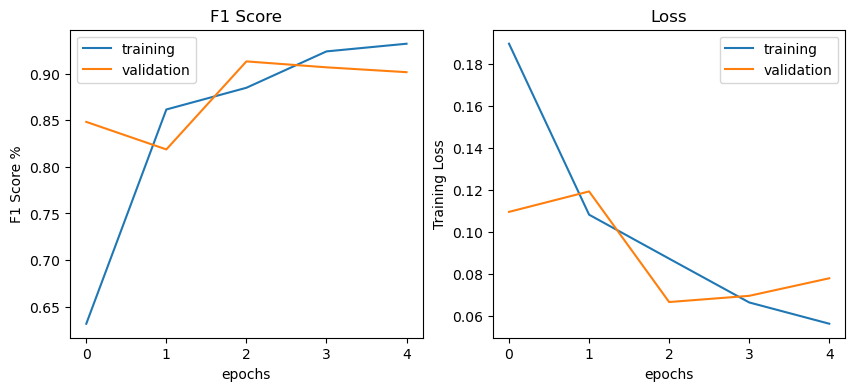

35/35 [==============================] - 2s 50ms/step
Fold 2


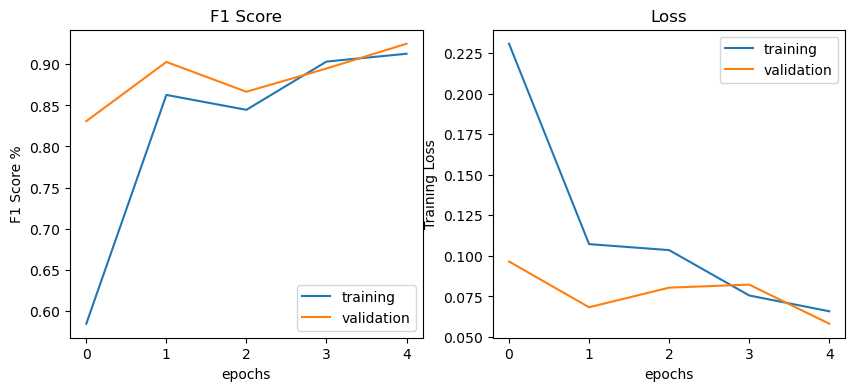

35/35 [==============================] - 2s 52ms/step
Fold 3


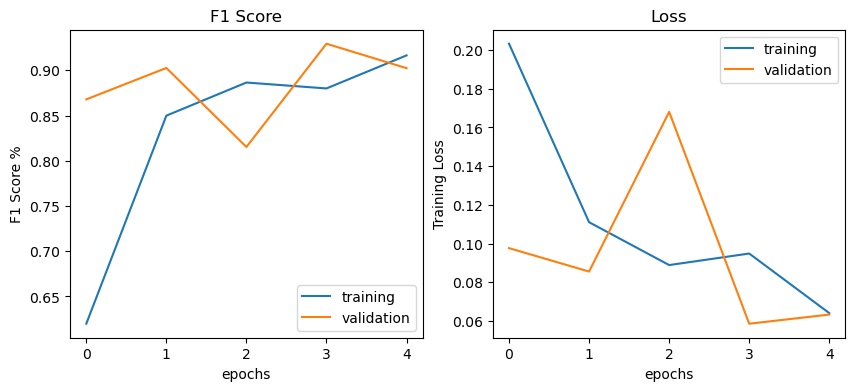

35/35 [==============================] - 2s 48ms/step
Fold 4


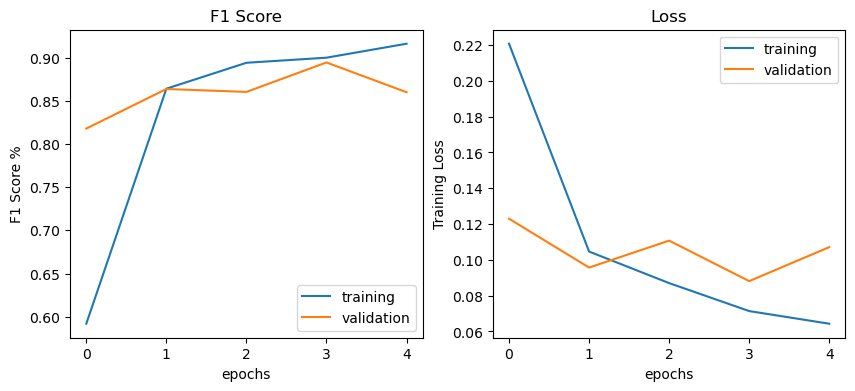

35/35 [==============================] - 2s 56ms/step
Fold 5


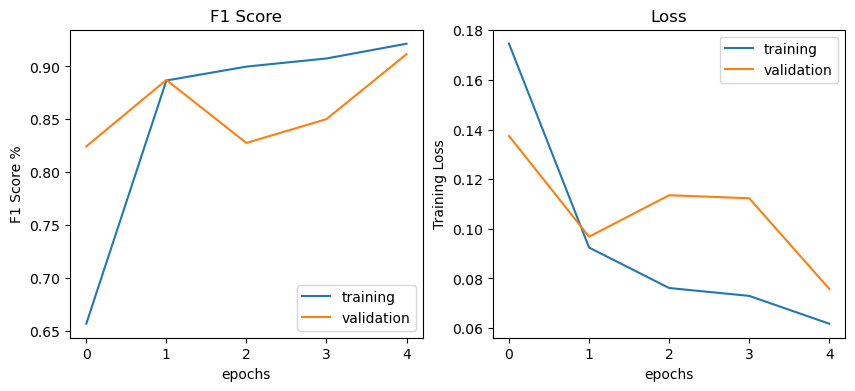

Average F1 Score: 0.9001371026039123


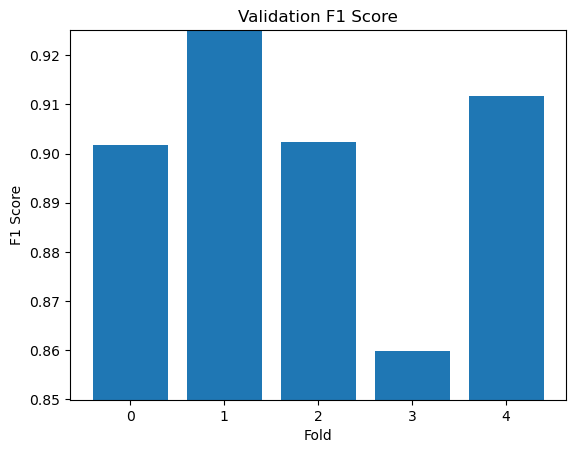

In [41]:
f1_scores_glove, mean_tpr_list_glove, auc_list_glove = get_f1_score(X, y, glove_transformer)

As seen above, our model using GloVe embeddings achieved an average F1 score of **90.01%**. Additionally, it had a variance of about 6% across all 5 folds. While these aren't the best numbers we've seen so far, they aren't horrible, and the loss graphs show that the model does indeed converge.

### 3.2 ConceptNet Numberbatch


ConceptNet Numberbatch is a pre-trained word embedding model derived from the ConceptNet project, which is a knowledge graph that connects words and phrases with common-sense knowledge. The Numberbatch embeddings offer a rich representation of words by including semantic relationships and contextual information. We will use the English version of the ConceptNet Numberbatch embeddings with a Transformer model to classify our dataset of text messages.

In [44]:
EMBED_SIZE = 300
embeddings_index = {}
f = open('data/numberbatch-en-17.04b.txt', encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


print('Found %s word vectors.' % len(embeddings_index))


# Now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
conceptnet_embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        conceptnet_embedding_matrix[i] = embedding_vector
        found_words = found_words+1


print("Embedding Shape:", conceptnet_embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/conceptnet_embedding_matrix.shape[0])

Found 418082 word vectors.
Embedding Shape: (8921, 300) 
 Total words found: 6193 
 Percentage: 69.42046855733662


In [45]:
class ConceptNetNumberBatch(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[conceptnet_embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
       
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN,
                                 EMBED_SIZE,
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )
       
    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x)
        return x + positions

In [46]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


def conceptnet_transformer(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = ConceptNetNumberBatch()(inputs)
    x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)


    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(NUM_CLASSES, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    conceptnet_xformer = Model(inputs=inputs, outputs=preds)
    conceptnet_xformer.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(), f1_metric])
   
    history = conceptnet_xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(conceptnet_xformer.predict(X_test))

    return history, yhat

35/35 [==============================] - 6s 148ms/step
Fold 1


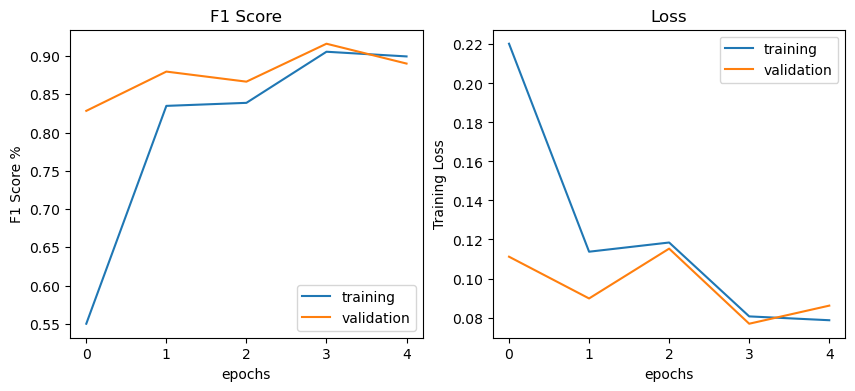

35/35 [==============================] - 6s 151ms/step
Fold 2


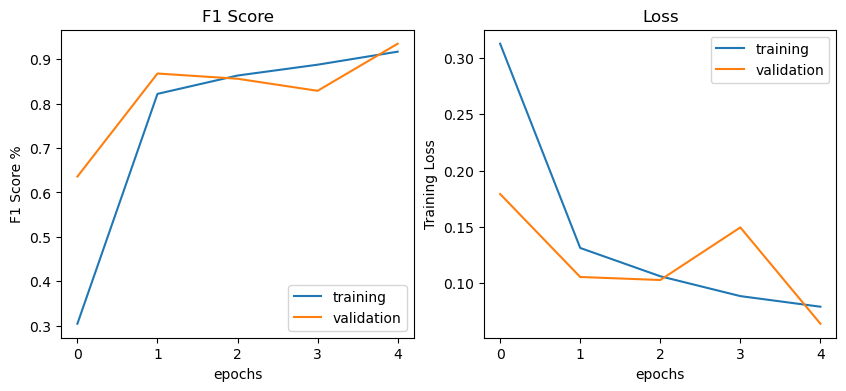

35/35 [==============================] - 6s 153ms/step
Fold 3


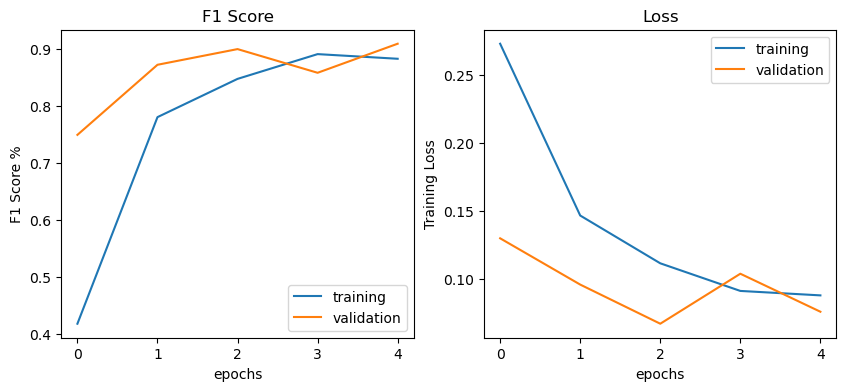

35/35 [==============================] - 6s 149ms/step
Fold 4


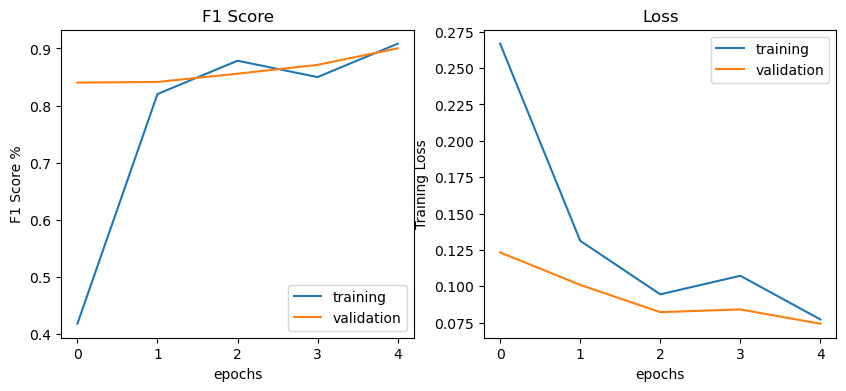

35/35 [==============================] - 6s 154ms/step
Fold 5


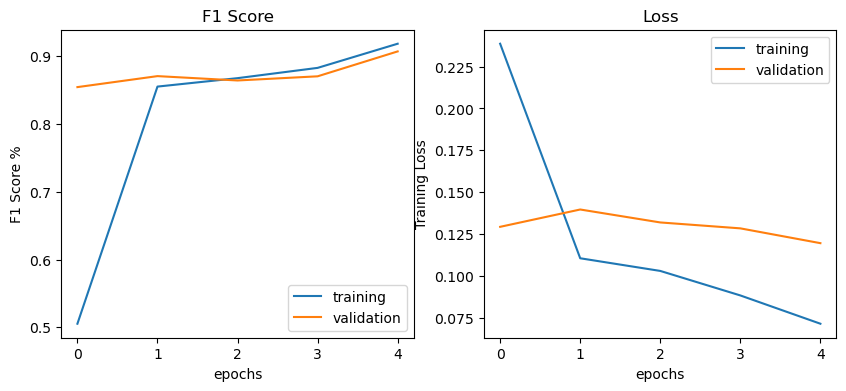

Average F1 Score: 0.9084140419960022


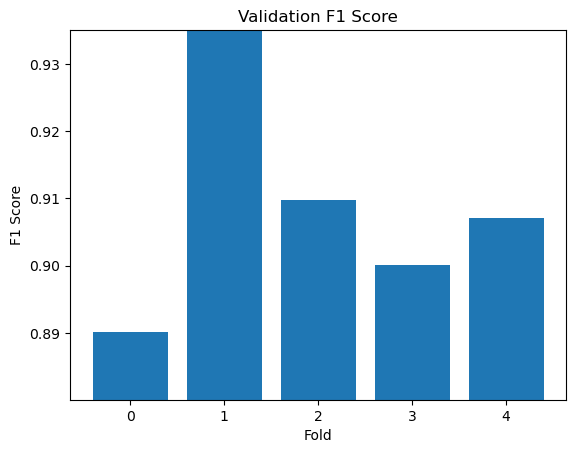

In [47]:
f1_scores_concept_net, mean_tpr_list_concept_net, auc_list_concept_net = get_f1_score(X, y, conceptnet_transformer)

As seen above, our model using ConceptNet Numberbatch embeddings achieved an average F1 score of **90.84%**, which is higher than our model using GloVe embeddings. Additionally, it had a smaller variance than the GloVe embeddings model across all 5 folds (about 4.5% vs 6%). The loss graphs, once again, show that this model converges to a solution. While it initially appears that this second model is better, let's plot their ROC curves and perform some statistical tests to find out for sure.

(0.8, 1.0)

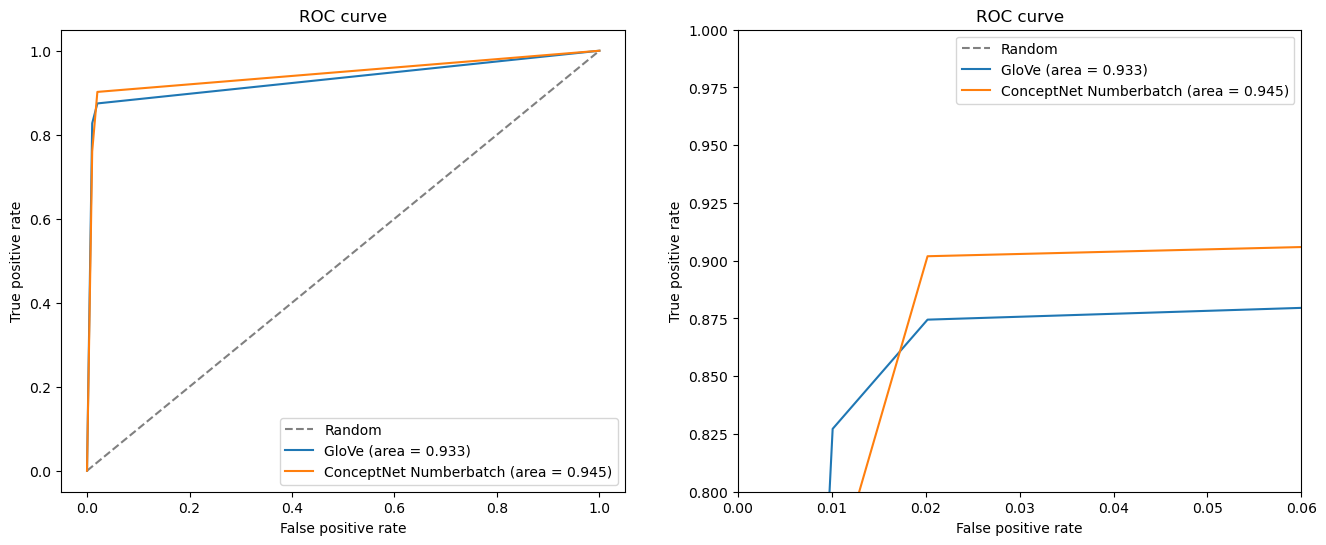

In [48]:
# Compare the 2 models using the receiver operating characteristic (ROC) curve
mean_tpr_glove = np.mean(mean_tpr_list_glove, axis=0)
mean_auc_glove = np.mean(auc_list_glove)

mean_tpr_concept_net = np.mean(mean_tpr_list_concept_net, axis=0)
mean_auc_concept_net = np.mean(auc_list_concept_net)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
plt.plot(mean_fpr, mean_tpr_glove, label='GloVe (area = {:.3f})'.format(mean_auc_glove))
plt.plot(mean_fpr, mean_tpr_concept_net, label='ConceptNet Numberbatch (area = {:.3f})'.format(mean_auc_concept_net))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

#Redo the above code but zoom in on the top left corner
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
plt.plot(mean_fpr, mean_tpr_glove, label='GloVe (area = {:.3f})'.format(mean_auc_glove))
plt.plot(mean_fpr, mean_tpr_concept_net, label='ConceptNet Numberbatch (area = {:.3f})'.format(mean_auc_concept_net))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.xlim(0, 0.06)
plt.ylim(0.8, 1)

As seen above, the model using ConceptNet Numberbatch embeddings has a higher AUC than the model using GloVe embeddings (0.945 vs. 0.933). This indicates that the model using ConceptNet Numberbatch embeddings is better at this classification task. Let's perform a statistical test to see if we can definitively make this claim.

In [49]:
t = 2.26 / np.sqrt(10)
e = (1 - np.mean(f1_scores_glove)) - (1 - np.mean(f1_scores_concept_net))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('GloVe and ConceptNet Numberbatch Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

#===================================================
print('\nGloVe F1 Score:', np.mean(f1_scores_glove))
print('ConceptNet Numberbatch F1 Score:', np.mean(f1_scores_concept_net))

GloVe and ConceptNet Numberbatch Range: 0.008276939392089844 0.008276939392089844

GloVe F1 Score: 0.9001371026039123
ConceptNet Numberbatch F1 Score: 0.9084140419960022


As seen above, the range obtained from the statistical test comparing the two models does not contain 0; thus, we can say with 95% confidence that the two models are different. We can then conclude that the model using ConceptNet Numberbatch embeddings, which has a higher average F1 score and a higher AUC than the model using GloVe embeddings, is the better model for our classification task. However, it is worth noting that both of these models are inferior to the 5 models we trained earlier in this report. Nevertheless, both of these models perform decently, proving the validity of these types of embeddings.